In [0]:
% matplotlib inline

# Diseño y construcción de red bayesiana

Ejercicio de _Eugene Charniak_.

Supongamos que he salido de casa por la noche y quiero saber si mi familia está en casa antes de entrar a partir del conocimiento probabilístico que tengo.

Mi mujer a menudo enciende la luz del porche cuando sale de casa, aunque también a veces la enciende cuando está esperando alguna visita en casa. Además, tenemos un perro. Cuando no hay nadie en casa al perro lo dejamos en el jardín trasero, aunque también a veces lo dejamos allí cuando tiene problemas estomacales. Cuando el perro está en el jardín trasero, se le suele oir ladrar (aunque a veces confundo sus ladridos con el de otros perros en la lejanía).

Las probabilidades de cada evento son:

- La probabilidad de que la **familia esté fuera** es, de media, el 15%.
- La probabilidad de que el perro tenga **problemas estomacales** es del 1%.
- Si la **luz está encendida**, el 60% de las ocasiones es debido a que la familia está fuera; y solo un 5% de las ocasiones es porque no lo está.
- Si el **perro está fuera** en el jardín trasero, es probable que sea porque la familia está fuera o porque está con **problemas estomacales**, más concretamente:
  - Si la familia está fuera y tiene problemas estomacales, la probabilidad de que esté fuera es del 99%; si no tiene problemas estomacales la probabilidad de que esté fuera es del 90%.
  - Si la familia no está fuera y no tiene problemas estomacales, la probabilidad de que esté fuera es del 30%; si tiene problemas estomacales la probabilidad de que esté fuera es del 97%.
- Si oigo ladridos, el 70% de las veces es que el perro está fuera, mientras que solo el 1% si no está fuera.

Nota: los nodos de la red bayesiana se han resaltado en negrita para facilitar su identificación.

## Práctica a realizar

Diseñar una red bayesiana que recoja la información planteada en el ejercicio. Dibujarla e insertar dicha imagen en el notebook.

Utilizando la biblioteca `pymc3` de Python modelar la red bayesiana planteada y responder a las siguientes cuestiones:
- Sabiendo que estoy escuchando ladridos: ¿cuál es la probabilidad de que la familia esté fuera? ¿cuál es la probabilidad de que tenga problemas estomacales?
- Explica y/o razona si hay nodos de dicha red que no son útiles para las dos cuestiones previas.

In [0]:
!pip install -q arviz

     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 4.1MB 41.9MB/s 
     |████████████████████████████████| 317kB 63.6MB/s 


In [0]:
import pymc3 as pm
import numpy as np
import pandas as pd

[DIAGRAMA](https://drive.google.com/open?id=1gNTVMQGmUMJIb1kMydk9nKRq4APruoEL)

En el caso de que no se visualizara el diagrama, se adjunta una copia en la entrega

In [0]:
# Muestras a "lanzar".
draws = 10000
# Muestras descartadas al inicio para ajustar.
tune = 1000

# Crear el modelo en PyMC3
modelo = pm.Model()

with modelo:
    tv = [1]
    
    #Familia fuera
    
    familia_Fuera = pm.Bernoulli('Familia_Fuera', 0.15, shape=1, testval=tv)
    
    #Problemas estomacales
    
    problemas_estomacales = pm.Bernoulli('Problemas_estomacales', 0.01, shape=1, testval=tv)
    
    #Luz encendida
    
    luz_encendida_p = pm.Deterministic('Luz_encendida_p', pm.math.switch(familia_Fuera, 0.6, 0.05)) 
    luz_encendida = pm.Bernoulli('Luz_encendida', luz_encendida_p, shape=1, testval=tv)
    
    #Perro Fuera
    
    perro_fuera_p = pm.Deterministic('Perro_Fuera_p',
                       pm.math.switch(familia_Fuera, 
                                 pm.math.switch(problemas_estomacales,0.99, 0.9),
                                 pm.math.switch(problemas_estomacales, 0.97, 0.3)))

    perro_fuera = pm.Bernoulli('Perro_Fuera', perro_fuera_p, observed=np.array([1]), shape=1)
    
    #Ladridos
    
    ladridos_p = pm.Deterministic('Ladridos_p', pm.math.switch(perro_fuera, 0.7, 0.01)) 
    ladridos = pm.Bernoulli('Ladridos', ladridos_p, shape=1, testval=tv)
    
    
    # Resolver por Monte Carlo perro ladrando y familia fuera.
    trace = pm.sample(draws, step=[pm.BinaryGibbsMetropolis([ladridos, familia_Fuera])], 
                      tune=tune, random_seed=1)
    
    # Resolver por Monte Carlo perro ladrando y el perro tenga problemas estomacales
    trace_1 = pm.sample(draws, step=[pm.BinaryGibbsMetropolis([ladridos, problemas_estomacales])], 
                      tune=tune, random_seed=1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [Ladridos, Familia_Fuera]
>BinaryGibbsMetropolis: [Problemas_estomacales, Luz_encendida]
100%|██████████| 11000/11000 [00:04<00:00, 2330.96it/s]
Sequential sampling (2 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [Ladridos, Problemas_estomacales]
>BinaryGibbsMetropolis: [Familia_Fuera, Luz_encendida]
100%|██████████| 11000/11000 [00:04<00:00, 2300.31it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f899e830b70>,
      dtype=object)

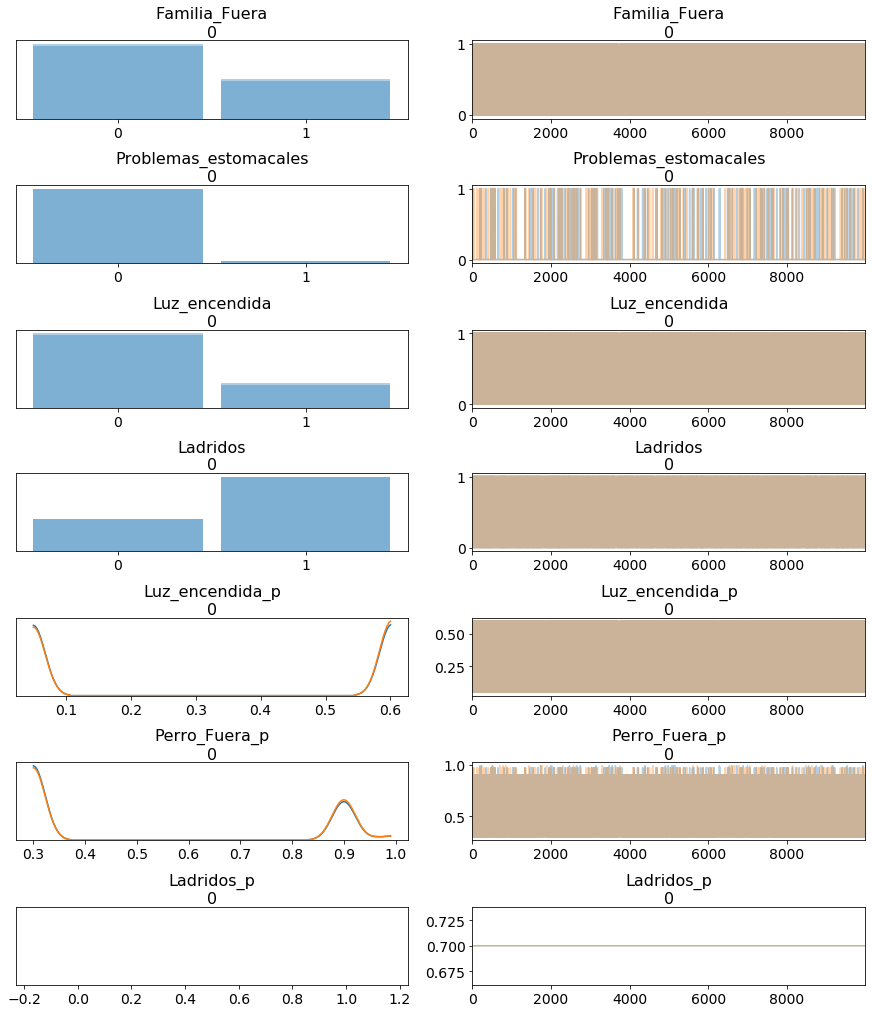

In [0]:
# Dibujar los graficos
pm.traceplot(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f899e6f52b0>,
      dtype=object)

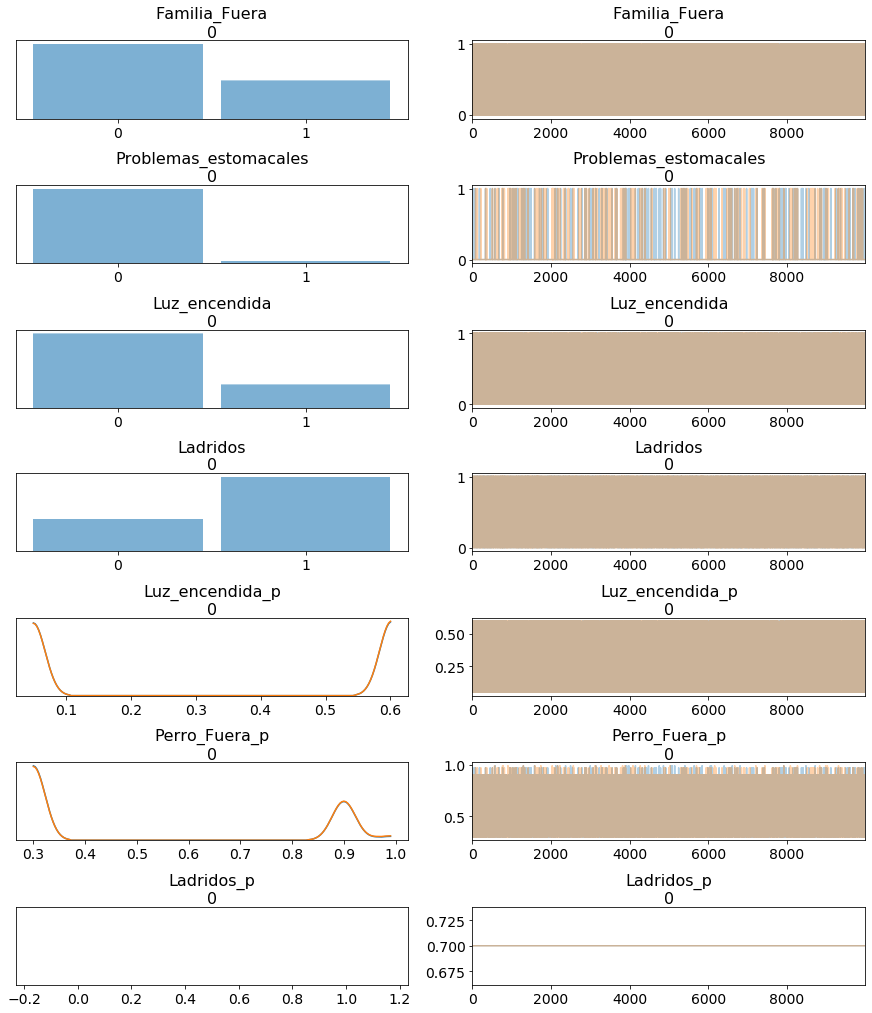

In [0]:
# Dibujar los graficos
pm.traceplot(trace_1)

In [0]:
# Crear un diccionario con los resultados de la traza.
dictionary = {
              'familia_Fuera': [1 if ii[0] else 0 for ii in trace['Familia_Fuera'].tolist() ],
              'problemas_estomacales': [1 if ii[0] else 0 for ii in trace['Problemas_estomacales'].tolist() ],
              'luz_encendida_p': [1 if ii[0] else 0 for ii in trace['Luz_encendida_p'].tolist() ],
              'perro_fuera_p': [ii[0] for ii in trace['Perro_Fuera_p'].tolist()],
              'ladridos_p': [ii[0] for ii in trace['Ladridos_p'].tolist()],
              }

dictionary_1 = {
              'familia_Fuera': [1 if ii[0] else 0 for ii in trace_1['Familia_Fuera'].tolist() ],
              'problemas_estomacales': [1 if ii[0] else 0 for ii in trace_1['Problemas_estomacales'].tolist() ],
              'luz_encendida_p': [1 if ii[0] else 0 for ii in trace_1['Luz_encendida_p'].tolist() ],
              'perro_fuera_p': [ii[0] for ii in trace_1['Perro_Fuera_p'].tolist()],
              'ladridos_p': [ii[0] for ii in trace_1['Ladridos_p'].tolist()],
              }

In [0]:
df = pd.DataFrame(dictionary)
df_1 = pd.DataFrame(dictionary_1)

df
df_1

,familia_Fuera,problemas_estomacales,luz_encendida_p,perro_fuera_p,ladridos_p
0,0,0,1,0.3,0.7
1,0,0,1,0.3,0.7
2,1,0,1,0.9,0.7
3,1,0,1,0.9,0.7
4,0,0,1,0.3,0.7
...,...,...,...,...,...
19995,0,0,1,0.3,0.7
19996,0,0,1,0.3,0.7
19997,1,0,1,0.9,0.7
19998,1,0,1,0.9,0.7


In [0]:
p_familia_Fuera = df[(df['familia_Fuera'] == 1)].shape[0] / df.shape[0]

p_problemas_estomacales = df[(df['problemas_estomacales'] == 1)].shape[0] / df.shape[0]

In [0]:
print("\nProbabilidad de que la probabilidad de que la familia esté fuera cuando el perro ladra es:", p_familia_Fuera)

print("\nProbabilidad de que la probabilidad de que el perro tenga problemas estomacales cuando el perro ladra es:", p_problemas_estomacales)


Probabilidad de que la probabilidad de que la familia esté fuera cuando el perro ladra es: 0.34485

Probabilidad de que la probabilidad de que el perro tenga problemas estomacales cuando el perro ladra es: 0.0237
